In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

### Data load

In [2]:
X_train1 = np.load('../ReactionClassification_2024/data/OptBertFPFinal1/X_train1_OptBertFP.npy',allow_pickle=True)
X_train2 = np.load('../ReactionClassification_2024/data/OptBertFPFinal1/X_train2_OptBertFP.npy',allow_pickle=True)
X_train3 = np.load('../ReactionClassification_2024/data/OptBertFPFinal1/X_train3_OptBertFP.npy',allow_pickle=True)
X_train4 = np.load('../ReactionClassification_2024/data/OptBertFPFinal1/X_train4_OptBertFP.npy',allow_pickle=True)
X_train5 = np.load('../ReactionClassification_2024/data/OptBertFPFinal1/X_train5_OptBertFP.npy',allow_pickle=True)
X_train6 = np.load('../ReactionClassification_2024/data/OptBertFPFinal1/X_train6_OptBertFP.npy',allow_pickle=True)
X_train7 = np.load('../ReactionClassification_2024/data/OptBertFPFinal1/X_train7_OptBertFP.npy',allow_pickle=True)
X_train8 = np.load('../ReactionClassification_2024/data/OptBertFPFinal1/X_train8_OptBertFP.npy',allow_pickle=True)
X_train9 = np.load('../ReactionClassification_2024/data/OptBertFPFinal1/X_train9_OptBertFP.npy',allow_pickle=True)
X_train10 = np.load('../ReactionClassification_2024/data/OptBertFPFinal1/X_train10_OptBertFP.npy',allow_pickle=True)
X_test = np.load('data/OptBertFPFinal1/X_test_OptBertFP.npy',allow_pickle=True)
X_val = np.load('data/OptBertFPFinal1/X_val_OptBertFP.npy',allow_pickle=True)

In [3]:
train = pd.read_csv('data/train.csv', delimiter=',')
test = pd.read_csv('data/test.csv', delimiter=',')
val = pd.read_csv('data/val.csv', delimiter=',')

In [4]:
y_train = train['CLASS-ID'].values
y_test = test['CLASS-ID'].values
y_val = val['CLASS-ID'].values

In [5]:
X_train = np.concatenate([X_train1, X_train2, X_train3, X_train4, X_train5,
                          X_train6, X_train7, X_train8, X_train9, X_train10], axis=0)
X_train1 = np.vstack(X_train)

In [6]:
X_train = np.squeeze(X_train1)
X_test = np.squeeze(X_test)
X_val = np.squeeze(X_val)

In [7]:
df_test1nn = pd.read_csv('data/OptBertFPFinal1/df_test1nn.csv', delimiter=',')

In [8]:
y_pred_test_1nn = np.load('data/OptBertFPFinal1/y_pred_test_1nn.npy')

### Evaluation

In [9]:
df_class = pd.read_csv('data/className.tsv', sep='\t', encoding='ISO-8859-1')

In [10]:
# Convert multi Class-ID into one
def clean_class_id(row):
    # Split the string by comma and convert to a list
    class_ids = str(row['CLASS-ID']).split(',')
    # Return the first element from the list, ensuring it's an integer
    return int(class_ids[0].strip())

# Apply the function to the 'CLASS-ID' column
df_class['CLASS-ID'] = df_class.apply(clean_class_id, axis=1)
df_class['CLASS-ID'] = df_class['CLASS-ID'].astype(int)

In [11]:
df_test1nn

,CLASS-ID,precision,recall,f1-score,test_support,train_support,TRANSFORM_NAME,TRANSFORM_ID
0,1085,0.999199,0.999199,0.999199,24966,185024,"Suzuki coupling, Suzuki-Miyaura Cross-Coupling","(ARCOUPLG)4.1.B, (AVNAMEDR)Suzuki-Miyaura"
1,432,0.985259,0.987205,0.986231,21259,164914,N-alkylation of alkylamines,(AG2ALKN)1.1.2
2,1016,0.994638,0.992842,0.993739,15507,113635,hydrolysis of carboxylic esters,(AQCLEAV1)1.1
3,60,0.999463,0.999106,0.999285,11185,85921,reduction of C-NO2 to C-NH2,(AAREDUCT)A.1
4,433,0.954267,0.957377,0.955820,7977,60554,"N-alkylation of benzenoid amines, anilines",(AG2ALKN)1.1.3
...,...,...,...,...,...,...,...,...
1294,1267,1.000000,1.000000,1.000000,1,8,Brackeen Imidazole Synthesis,(AVNAMEDR)Brackeen
1295,1800,1.000000,1.000000,1.000000,5,8,Shestakov Hydrazino Acid Synthesis,(AVNAMEDR)Shestakov
1296,500,0.000000,0.000000,0.000000,1,7,"O-propargylation of N-hydroxy amides, includin...",(AG2ALKO)2.4.1
1297,1622,1.000000,1.000000,1.000000,1,7,ListMacMillan Hydrogenation,(AVNAMEDR)List-MacMillan


In [12]:
df_test1nn['SUPER_TRANSFORM_ID'] = df_test1nn['TRANSFORM_ID'].str.extract(r'\((.*?)\)')

In [13]:
def weighted_mean(values, weights):
    return (values * weights).sum() / weights.sum()

In [14]:
grouped = df_test1nn.groupby('SUPER_TRANSFORM_ID')

grouped_metrics = grouped.apply(lambda x: pd.Series({
    'weighted_precision': weighted_mean(x['precision'], x['test_support']),
    'weighted_recall': weighted_mean(x['recall'], x['test_support']),
    'weighted_f1-score': weighted_mean(x['f1-score'], x['test_support']),
    'total_test_support': x['test_support'].sum(),
    'total_train_support': x['train_support'].sum(),
    'class_count': len(x)
}))

In [15]:
grouped_metrics.sort_values(by=['SUPER_TRANSFORM_ID'])

,weighted_precision,weighted_recall,weighted_f1-score,total_test_support,total_train_support,class_count
SUPER_TRANSFORM_ID,,,,,,
AAREDUCT,0.981086,0.979478,0.980215,36644.0,250984.0,53.0
ABOXIDAT,0.897265,0.898037,0.897365,24813.0,175151.0,105.0
ACADD,0.971896,0.976854,0.974280,15640.0,114981.0,37.0
ADELIMIN,0.980258,0.978685,0.979420,10650.0,67085.0,21.0
AEREARR,0.958922,0.957763,0.957378,2486.0,17393.0,36.0
AFCYCLIZ,0.953758,0.948087,0.950662,4026.0,31313.0,30.0
AG1ARYL,0.952004,0.964194,0.957951,7373.0,55032.0,20.0
AG2ALKC,0.897454,0.902604,0.898717,3840.0,26254.0,58.0
AG2ALKN,0.974853,0.974431,0.974583,35864.0,270086.0,16.0


In [16]:
# Calculate macro average for precision, recall, and f1-score
macro_precision2 = df_test1nn['precision'].mean()
macro_recall2 = df_test1nn['recall'].mean()
macro_f12 = df_test1nn['f1-score'].mean()

# Calculate weighted average for precision, recall, and f1-score
weighted_precision2 = (df_test1nn['precision'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_recall2 = (df_test1nn['recall'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_f12 = (df_test1nn['f1-score'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()

In [17]:
output1 = f"""
Macro-averages:
- Precision: {macro_precision2:.4f}
- Recall: {macro_recall2:.4f}
- F1-score: {macro_f12:.4f}

Weighted-averages:
- Precision: {weighted_precision2:.4f}
- Recall: {weighted_recall2:.4f}
- F1-score: {weighted_f12:.4f}
"""

In [18]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_test_1nn)}')

Accuracy: 0.961824007738581


In [19]:
print(output1)


Macro-averages:
- Precision: 0.8882
- Recall: 0.8757
- F1-score: 0.8757

Weighted-averages:
- Precision: 0.9618
- Recall: 0.9618
- F1-score: 0.9616



In [20]:
summary_stats = df_test1nn[["precision", "recall", "f1-score", "test_support", "train_support"]].describe()
summary_stats

,precision,recall,f1-score,test_support,train_support
count,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000
mean,0.888229,0.875718,0.875661,254.665127,1851.890685
std,0.189184,0.200053,0.189174,1212.528218,9034.637418
min,0.000000,0.000000,0.000000,1.000000,7.000000
25%,0.867525,0.841879,0.847258,6.000000,39.000000
50%,0.961538,0.959202,0.947368,24.000000,160.000000
75%,1.000000,1.000000,0.990752,110.500000,811.000000
max,1.000000,1.000000,1.000000,24966.000000,185024.000000


In [21]:
low_f1_reactions = df_test1nn[df_test1nn['f1-score'] < df_test1nn['f1-score'].quantile(0.25)].head(10)

### Wrong predict evaluation in details

In [22]:
class_to_transform_id = pd.Series(df_class['TRANSFORM_ID'].values,index=df_class['CLASS-ID']).to_dict()

In [23]:
y_pred_flattened = y_pred_test_1nn.flatten() 

In [24]:
mismatches = y_pred_flattened != y_test

full_comparison_df = pd.DataFrame({
    'CLASS-ID': y_test,
    'CLASS-ID-predict': y_pred_flattened,
    'Misclassified': mismatches
})

misclassified_df = full_comparison_df[full_comparison_df['Misclassified'] == True].sort_values(by=['CLASS-ID', 'CLASS-ID-predict'])

In [25]:
counts = misclassified_df.groupby(['CLASS-ID', 'CLASS-ID-predict']).size().reset_index(name='Count')
top_counts = (counts.sort_values(by=['CLASS-ID', 'Count'], ascending=[True, False])
             .groupby('CLASS-ID')
             .head(3))

In [26]:
reshaped_df = pd.DataFrame()
rows = []
for i, group in top_counts.groupby('CLASS-ID'):
    reshaped_row = {'CLASS-ID': i}
    for j, (index, row) in enumerate(group.iterrows(), start=1):
        reshaped_row[f'Top{j}_CLASS-ID-predict'] = row['CLASS-ID-predict']
        reshaped_row[f'Top{j}_Count'] = row['Count']
    rows.append(reshaped_row)

# Use concat instead of append
reshaped_df = pd.concat([reshaped_df, pd.DataFrame(rows)], ignore_index=True)

# Process columns as needed
reshaped_df = reshaped_df[['CLASS-ID'] + [col for col in reshaped_df.columns if col != 'CLASS-ID']].fillna(0).astype(int)

In [27]:
reshaped_df['Top1_MISTRANSFORM_ID'] = reshaped_df['Top1_CLASS-ID-predict'].map(class_to_transform_id)
reshaped_df['Top2_MISTRANSFORM_ID'] = reshaped_df['Top2_CLASS-ID-predict'].map(class_to_transform_id)
reshaped_df['Top3_MISTRANSFORM_ID'] = reshaped_df['Top3_CLASS-ID-predict'].map(class_to_transform_id)

In [28]:
df_low = pd.merge(low_f1_reactions, reshaped_df[['CLASS-ID', 'Top1_MISTRANSFORM_ID', 'Top1_Count', 'Top2_MISTRANSFORM_ID', 'Top2_Count', 'Top3_MISTRANSFORM_ID', 'Top3_Count']], on='CLASS-ID', how='left')

In [29]:
df_low

,CLASS-ID,precision,recall,f1-score,test_support,train_support,TRANSFORM_NAME,TRANSFORM_ID,SUPER_TRANSFORM_ID,Top1_MISTRANSFORM_ID,Top1_Count,Top2_MISTRANSFORM_ID,Top2_Count,Top3_MISTRANSFORM_ID,Top3_Count
0,109,0.805257,0.818955,0.812048,1646,12611,"Dess-Martin ketone synthesis, Dess-Martin oxid...","(ABOXIDAT)5.2.3, (AVNAMEDR)Dess-Martin1.2",ABOXIDAT,(AVNAMEDR)Corey-Suggs,167,"(ABOXIDAT)5.2.1, (AVNAMEDR)Swern1.2",107,"(ABOXIDAT)5.2.2, (AVNAMEDR)Jones1.1.2",11
1,1331,0.707071,0.713857,0.710448,1667,12096,Corey-Suggs Reagent,(AVNAMEDR)Corey-Suggs,AVNAMEDR,"(ABOXIDAT)5.2.3, (AVNAMEDR)Dess-Martin1.2",174,"(ABOXIDAT)5.1.3, (AVNAMEDR)Dess-Martin1.1",112,"(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",95
2,99,0.752078,0.751557,0.751817,1445,10979,"Dess-Martin aldehyde synthesis, Dess-Martin ox...","(ABOXIDAT)5.1.3, (AVNAMEDR)Dess-Martin1.1",ABOXIDAT,"(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",205,(AVNAMEDR)Corey-Suggs,117,"(ABOXIDAT)5.1.4, (AVNAMEDR)Parikh-Doering1.1",18
3,864,0.851266,0.817629,0.834109,1316,10486,condensation of heteroaryl aldehydes with hydr...,(AHCONDEN)7.1.3,AHCONDEN,(AHCONDEN)7.1.2,229,(AHCONDEN)7.1.1,10,(AHCONDEN)8.1.2,1
4,97,0.671717,0.679959,0.675813,978,7239,"Swern aldehyde synthesis, Swern oxidation of a...","(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",ABOXIDAT,"(ABOXIDAT)5.1.3, (AVNAMEDR)Dess-Martin1.1",203,(AVNAMEDR)Corey-Suggs,90,"(ABOXIDAT)5.1.4, (AVNAMEDR)Parikh-Doering1.1",12
5,44,0.868981,0.816842,0.842105,950,6185,"alkene reduction of alpha,beta unsaturated car...",(AAREDUCT)4.4.2,AAREDUCT,(ACADD)1.1.1,128,(AAREDUCT)4.3,29,(ACADD)1.2.1,6
6,868,0.801431,0.801431,0.801431,559,4429,condensation of heteroaryl alkyl ketones with ...,(AHCONDEN)7.2.4,AHCONDEN,(AHCONDEN)7.2.2,76,(AHCONDEN)7.2.1,26,(AHCONDEN)7.2.5,6
7,79,0.835470,0.828390,0.831915,472,3686,"osmylation of alkenes to 1,2-diols",(ABOXIDAT)2.1.1,ABOXIDAT,(ABOXIDAT)2.1.2,36,(ABOXIDAT)2.1.3,31,(ABOXIDAT)2.1.4,6
8,107,0.552752,0.548975,0.550857,439,3377,"Swern oxidation of alcohols to ketones, Swern ...","(ABOXIDAT)5.2.1, (AVNAMEDR)Swern1.2",ABOXIDAT,"(ABOXIDAT)5.2.3, (AVNAMEDR)Dess-Martin1.2",116,(AVNAMEDR)Corey-Suggs,70,"(ABOXIDAT)5.2.2, (AVNAMEDR)Jones1.1.2",4
9,772,0.758278,0.750820,0.754530,305,2370,O-silylation of tertiary alkanols,(AG7SILYL)3.1.3,AG7SILYL,(AG7SILYL)3.1.2,65,(AG7SILYL)3.1.1,7,(AG7SILYL)3.2,3


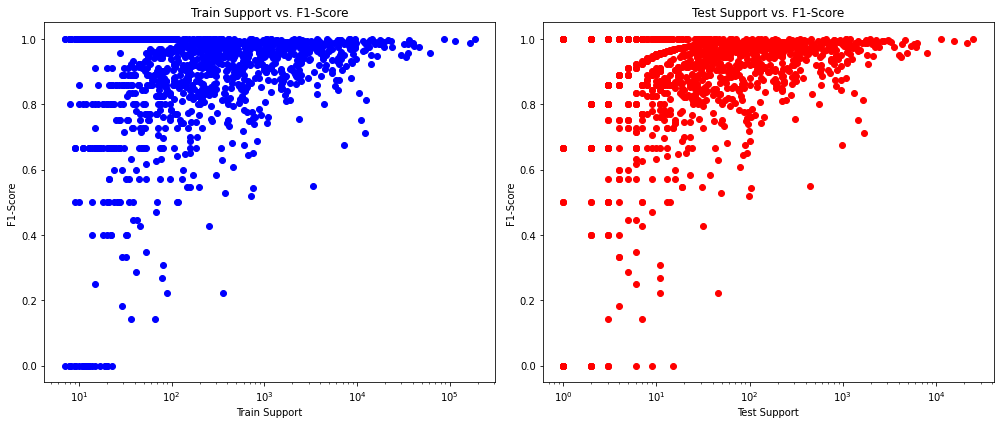

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(df_test1nn['train_support'], df_test1nn['f1-score'], color='blue')
ax1.set_title('Train Support vs. F1-Score')
ax1.set_xlabel('Train Support')
ax1.set_ylabel('F1-Score')
ax1.set_xscale('log')  # Set x-axis to log scale

ax2.scatter(df_test1nn['test_support'], df_test1nn['f1-score'], color='red')
ax2.set_title('Test Support vs. F1-Score')
ax2.set_xlabel('Test Support')
ax2.set_ylabel('F1-Score')
ax2.set_xscale('log')  # Set x-axis to log scale

plt.tight_layout()
plt.show()

### Manual test(Will be improved)

In [31]:
Manually_input = 'CC(=O)OC(\\C=C\\c1ccccc1)C#N>>CC(=O)OC(CC(=O)c1ccccc1)C#N'

In [32]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Assuming `X_val` is your validation embeddings and `y_val` is the corresponding labels
# Here we take a subset of the validation set for visualization purposes
subset_size = 1000  # Adjust this size based on your dataset and available computational resources
indices = np.random.choice(len(X_val), subset_size, replace=False)
X_val_subset = X_val[indices]
y_val_subset = y_val[indices]

/opt/conda/envs/reaction-workbench-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_val_umap = reducer.fit_transform(X_val_subset)

In [ ]:


# Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_val_umap = reducer.fit_transform(X_val_subset)

# Create a scatter plot of the embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1], c=y_val_subset, cmap='Spectral', s=5, alpha=0.7)
plt.colorbar(scatter)
plt.title('UMAP projection of the validation set embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

/opt/conda/envs/reaction-workbench-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
